In [1]:
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
from time import perf_counter 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

[nltk_data] Downloading package punkt to /Users/kristian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train = pd.read_csv('data/all/train_prepro.csv')
test = pd.read_csv('data/all/dev_prepro.csv')
train.columns = ['text', 'variety', 'group']
test.columns = ['text', 'variety', 'group']
sets = [train, test]

#keep only where group is bks
train = train[train.group == 'bks']
test = test[test.group == 'bks']

print(train.variety.value_counts())
print(test.variety.value_counts())

train.head()

variety
hr    18754
sr    18723
bs    18512
Name: count, dtype: int64
variety
sr    1984
bs    1970
hr    1962
Name: count, dtype: int64


,text,variety,group
0,miliona maloljetnih djevoj ica prisilno stupi...,bs,bks
1,nakon ovih kalkulacija ubrzo je postalo jasno...,bs,bks
2,u okviru programa modul memorije internacional...,bs,bks
3,sagra en je po istom principu kao i sli ni gra...,bs,bks
4,kontroverzni biznismen naser kelmendi koji se ...,bs,bks


<Figure size 1200x800 with 0 Axes>

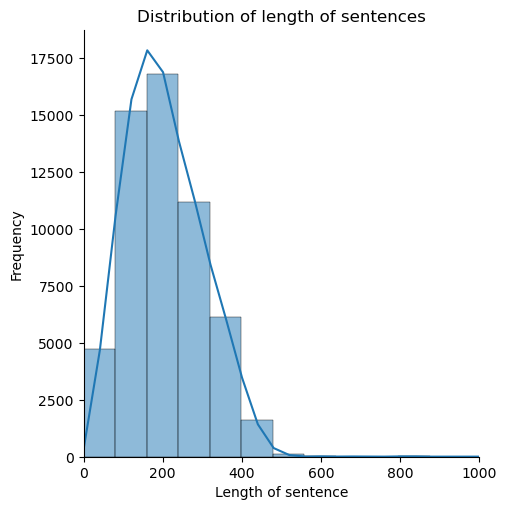

In [3]:
plt.figure(figsize=(12,8))
sns.displot(train.text.str.len(), bins=100, kde=True, rug=False)
plt.xlim(0,1000)
plt.xlabel('Length of sentence')
plt.ylabel('Frequency')
plt.title('Distribution of length of sentences')
plt.show()

In [4]:
quantile = 0.99
max_len = int(np.quantile(train.text.str.len(), quantile))
print(f'99% of sentences have length <= {max_len}')


99% of sentences have length <= 444


In [5]:
le = LabelEncoder()

variety2id= dict(zip(le.fit_transform(train.variety.unique()), train.variety.unique()))
train['variety_encoded'] = le.transform(train.variety)
test['variety_encoded'] = le.transform(test.variety)
variety2id


/var/folders/8v/5_c7kn_13jsgmgqz56r3yx440000gp/T/ipykernel_5407/1590294856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['variety_encoded'] = le.transform(train.variety)
/var/folders/8v/5_c7kn_13jsgmgqz56r3yx440000gp/T/ipykernel_5407/1590294856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['variety_encoded'] = le.transform(test.variety)


{0: 'bs', 1: 'hr', 2: 'sr'}

In [6]:
train.tail(5)

,text,variety,group,variety_encoded
162174,na kraju ete se osje ati mnogo bolje i svje ij...,bs,bks,0
162175,prema bari i evom iskazu dok je na elu stranke...,hr,bks,1
162180,guverner rohatinski ima potrebu pobje i od pro...,hr,bks,1
162185,projektant pekovi izvijestio je gradona elnika...,hr,bks,1
162189,premijer i ministar unutra njih poslova ivica ...,bs,bks,0


In [7]:
def evaluate_and_plot(model, X, y_true, title):
    """
    Function to evaluate a model and plot a confusion matrix.

    Parameters
    ----------
    model : sklearn model
        Model to evaluate.
    X : array-like
        Features.
    y_true : array-like
        True labels.
    title : str
        Title of the plot.

    Returns
    -------
    None.
    """

    y_pred = model.predict(X)

    f1 = f1_score(y_true, y_pred, average='weighted')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}\nF1 Score: {f1:.4f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    report = classification_report(y_true, y_pred)
    print(f"Classification Report - {title}:\n{report}")

In [8]:
def visualize_results(model, X, y_true, text_data, num_samples=15):
    num_samples = min(num_samples, X.shape[0]) 
    random_samples = random.sample(range(X.shape[0]), num_samples)

    for idx in random_samples:
        input_text = text_data.iloc[idx]
        true_label = y_true.iloc[idx]

        if hasattr(model, 'predict_proba'):
            # For classifiers that support probability predictions
            prob_scores = model.predict_proba(X[idx])
            predicted_label = model.predict(X[idx])[0]
        else:
            # For classifiers that do not support probability predictions
            predicted_label = model.predict(X[idx])

        # Print results
        print(f"Input Text:\n{input_text}")
        print(f"\nTrue Label: {true_label}")
        print(f"Predicted Label: {predicted_label}")

        if hasattr(model, 'predict_proba'):
            print(f"Predicted Probabilities:\n{prob_scores}")

        print("\n" + "="*50 + "\n")

Vocabulary size: 133211

In [9]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=100000)

X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train_group = train_data['variety_encoded']

X_val = tfidf_vectorizer.transform(val_data['text'])
X_test = tfidf_vectorizer.transform(test['text'])

classifier_group = LinearSVC()
classifier_group.fit(X_train, y_train_group)

y_val_group_pred = classifier_group.predict(X_val)
y_test_group_pred = classifier_group.predict(X_test)


/Users/kristian/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [10]:
conf_matrix_test_group = confusion_matrix(test['variety_encoded'], y_test_group_pred)
class_report_test_group = classification_report(test['variety_encoded'], y_test_group_pred)

print("\nConfusion Matrix (Test Set - Group Classification):")
print(conf_matrix_test_group)

print("\nClassification Report (Test Set - Group Classification):")
print(class_report_test_group)


Confusion Matrix (Test Set - Group Classification):
[[1444  301  225]
 [ 283 1617   62]
 [ 214   32 1738]]

Classification Report (Test Set - Group Classification):
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1970
           1       0.83      0.82      0.83      1962
           2       0.86      0.88      0.87      1984

    accuracy                           0.81      5916
   macro avg       0.81      0.81      0.81      5916
weighted avg       0.81      0.81      0.81      5916



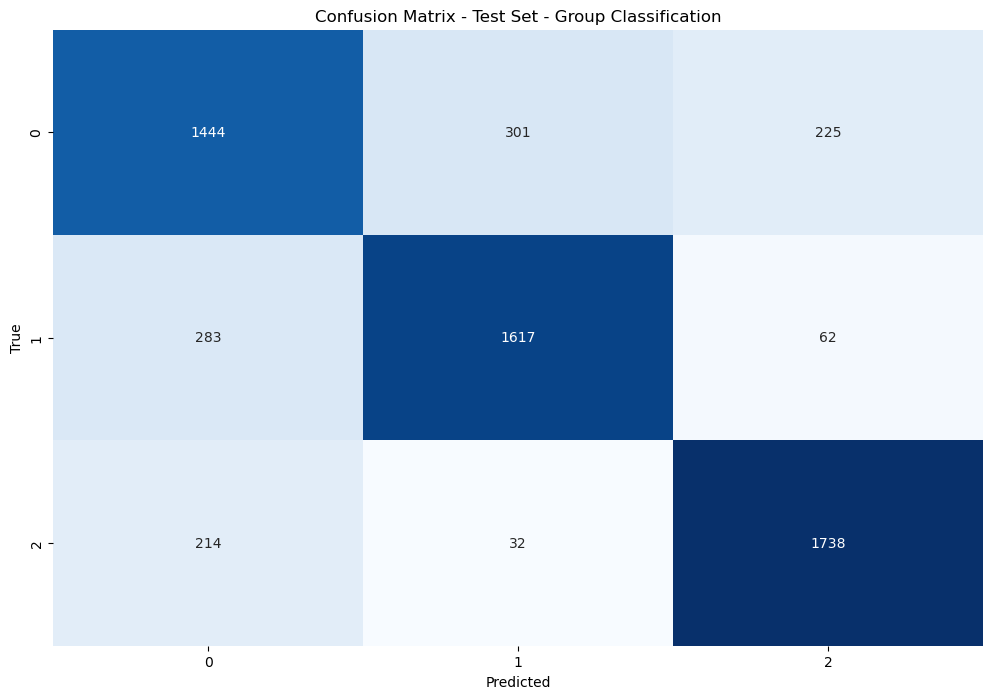

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix_test_group, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - Test Set - Group Classification")
plt.xlabel("Predicted") 
plt.ylabel("True")
plt.show()
